In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
from scipy.integrate import simps
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from scipy import integrate
from helpers import Fy, find_closest_element, get_densities, get_cdf, predict_single_density
import statsmodels.api as sm
from compute_dens import comp_dens

In [2]:
# read in val data
B_zeta = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/B_zeta_val.npy')
true_y = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/labels_val.npy')
B_zeta = B_zeta[np.abs(true_y) < 50,:] 
true_y = true_y[np.abs(true_y) < 50]

density_path = '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

no_points = 750
grid = np.linspace(min(density['axes']), max(density['axes']), no_points) #support #

In [3]:
# estimate density 
kde = sm.nonparametric.KDEUnivariate(true_y)
kde.fit()
support = kde.support
endog = kde.endog
density_gauss = kde.density

In [4]:
#dens_pred = comp_dens(density, no_points, B_zeta)
#va_horse = dens_pred.compute_dens('va_horseshoe')
#hmc_horse = dens_pred.compute_dens('hmc_horseshoe')
#va_ridge = dens_pred.compute_dens('va_ridge')
#hmc_ridge = dens_pred.compute_dens('hmc_ridge')

100%|██████████| 94805/94805 [07:49<00:00, 201.92it/s]


In [6]:
#np.save('../../../../data/commaai/calibration/cil_dens/va_horse_densities.npy', va_horse['densities'])
#np.save('../../../../data/commaai/calibration/cil_dens/hmc_horse_densities.npy', hmc_horse['densities'])
#np.save('../../../../data/commaai/calibration/cil_dens/va_ridge_densities.npy', va_ridge['densities'])
#np.save('../../../../data/commaai/calibration/cil_dens/hmc_ridge_densities.npy', hmc_ridge['densities'])

In [ ]:
#np.save('../../../data/commaai/calibration/cil_dens/grid.npy', grid)

In [4]:
va_horse_dens = np.load('../../../../data/commaai/calibration/cil_dens/va_horse_densities.npy')
hmc_horse_dens = np.load('../../../../data/commaai/calibration/cil_dens/hmc_horse_densities.npy')
va_ridge_dens = np.load('../../../../data/commaai/calibration/cil_dens/va_ridge_densities.npy')
hmc_ridge_dens = np.load('../../../../data/commaai/calibration/cil_dens/hmc_ridge_densities.npy')

No handles with labels found to put in legend.


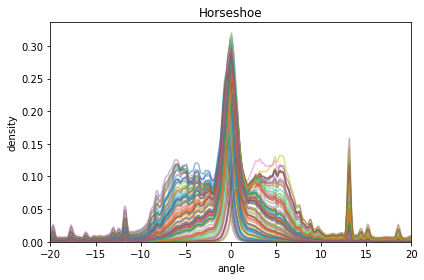

In [38]:
for dens in va_horse_dens[0::900]:
    plt.plot(grid, dens, alpha = 0.5)
plt.xlim(-20,20)
plt.ylim(0,)
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
plt.title('Horseshoe')
plt.tight_layout()
plt.savefig('random_dens_cil_horse.png')

No handles with labels found to put in legend.


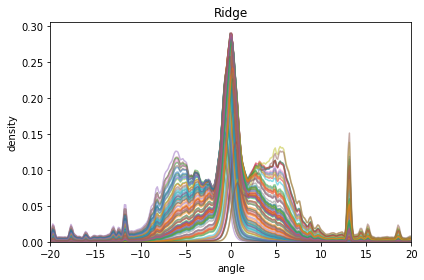

In [39]:
for dens in va_ridge_dens[0::900]:
    plt.plot(grid, dens, alpha = 0.5)
plt.xlim(-20,20)
plt.ylim(0,)
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
plt.title('Ridge')
plt.tight_layout()
plt.savefig('random_dens_cil_ridge.png')

## Marginal calibration

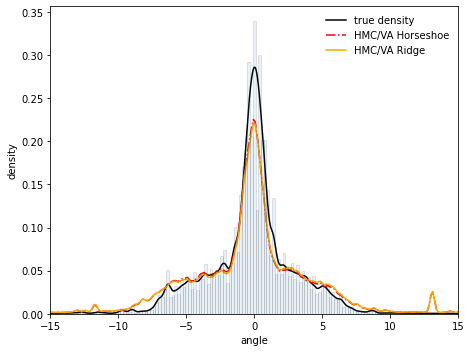

In [8]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.plot(support, density_gauss, color = 'black', label = 'true density')
ax.hist(true_y, bins=500, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.plot(grid, va_horse['av_density'], color = 'red', linestyle = '-.', label = 'HMC/VA Horseshoe')
ax.plot(grid, va_ridge['av_density'], color = 'orange', label = 'HMC/VA Ridge')
#ax.plot(grid, hmc_ridge['av_density'], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
#ax.plot(grid, hmc_horse['av_density'], color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.set_xlim(-15,15)
ax.legend()
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration_cil.png') 

## Marginal Calibration 2

In [9]:
# get cdfs
def f_integral(i):
        return(integrate.trapz(va_horse['av_density'][i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_horse['cdf'] = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_horse['av_density'][i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_horse['cdf'] = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(va_ridge['av_density'][i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_ridge['cdf'] = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_ridge['av_density'][i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_ridge['cdf'] = np.cumsum(np.array(probs))

In [10]:
Gt = []
for i in tqdm(grid):
    Gt.append(sum(x <= i for x in true_y))
Gt = np.array(Gt)/len(true_y)

100%|██████████| 750/750 [06:00<00:00,  2.08it/s]


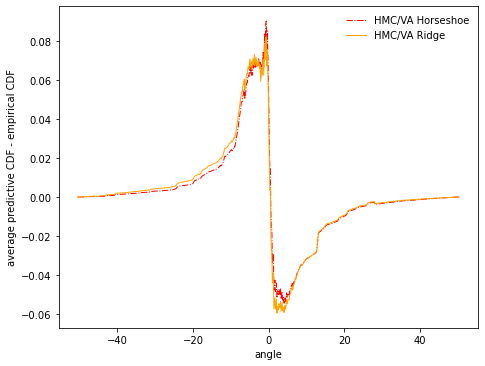

In [12]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(grid, va_horse['cdf'] - Gt,  color = 'red', label = 'HMC/VA Horseshoe', linestyle = '-.', linewidth = 1)
ax.plot(grid, va_ridge['cdf'] - Gt, color = 'orange', label = 'HMC/VA Ridge', linewidth = 1)
#ax.plot(grid, hmc_horse['cdf'] - Gt,  color = 'blue', label = 'VA/Horseshoe', linestyle = '-.', linewidth = 1)
#ax.plot(grid, hmc_ridge['cdf'] - Gt, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.legend()
plt.legend(framealpha=0.0)
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.xlabel('angle')
plt.autoscale()
plt.ylabel('average predictive CDF - empirical CDF')
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration2_cil.png') 

## Probability Calibration

In [13]:
help_grid = [find_closest_element(grid_i, support) for grid_i in grid]

In [14]:
# true density
grid2 = np.array([i for i in range(0, support.shape[0])])
def f_integral(i):
    return(integrate.trapz(density_gauss[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, grid2)
cdf = np.cumsum(np.array(probs))

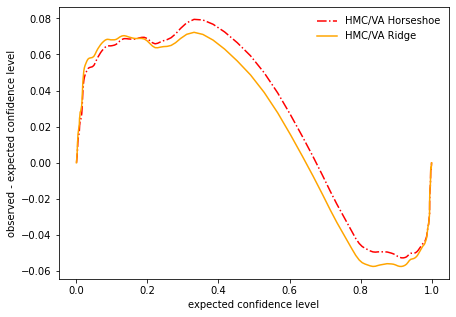

In [16]:
# plot like in Klein Paper
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
#ax.plot(cdf, cdf_va- cdf, color = 'red', label = 'VA/Horseshoe')
ax.plot(cdf[help_grid], va_horse['cdf'] - cdf[help_grid], color = 'red', linestyle= '-.', label = 'HMC/VA Horseshoe')
ax.plot(cdf[help_grid], va_ridge['cdf'] - cdf[help_grid], color = 'orange', label = 'HMC/VA Ridge') #*0.9292
ax.legend()
plt.legend(framealpha=0.0)
#plt.tight_layout()
plt.autoscale()
#plt.ylim(-.2,.2)
plt.xlabel('expected confidence level')
plt.ylabel('observed - expected confidence level')
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/prob_calibration_cil.png') 

## Create CDF_i for prediction intervals

In [ ]:
# va_horse
densities = va_horse['densities'][::6]
cdf_va_is = []
j = 0
for supp in tqdm(densities):
    dens = densities[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], grid[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_va_is.append(cdf_va_i)
    j += 1
cdf_va_is = np.array(cdf_va_is)
np.save('../../../data/commaai/calibration/cil_dens/va_horse_cdf_is.npy', cdf_va_is)

# hmc_horse
densities = hmc_horse['densities'][::6]
cdf_va_is = []
j = 0
for supp in tqdm(densities):
    dens = densities[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], grid[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_va_is.append(cdf_va_i)
    j += 1
cdf_va_is = np.array(cdf_va_is)
np.save('../../../data/commaai/calibration/cil_dens/hmc_horse_cdf_is.npy', cdf_va_is)

# va_ridge
densities = va_ridge['densities'][::6]
cdf_va_is = []
j = 0
for supp in tqdm(densities):
    dens = densities[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], grid[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_va_is.append(cdf_va_i)
    j += 1
cdf_va_is = np.array(cdf_va_is)
np.save('../../../data/commaai/calibration/cil_dens/va_ridge_cdf_is.npy', cdf_va_is)

# hmc_ridge
densities = hmc_ridge['densities'][::5]
cdf_va_is = []
j = 0
for supp in tqdm(densities):
    dens = densities[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], grid[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_va_is.append(cdf_va_i)
    j += 1
cdf_va_is = np.array(cdf_va_is)
np.save('../../../data/commaai/calibration/cil_dens/hmc_ridge_cdf_is.npy', cdf_va_is)